In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from my_alg_lib import *
import math
import sys
import itertools

#https://medium.com/swlh/ray-tracing-from-scratch-in-python-41670e6a96f9

In [2]:
epsilon = sys.float_info.epsilon

In [3]:
# funcao utilitaria que normaliza o vetor
def normalize(vector):
    return vector / np.linalg.norm(vector)

In [4]:
class Camera:
    def __init__(self, w, h, fovy, f):
        self.w = w
        self.h = h
        self.fov = fovy
        self.f = f
        self.a = 2 * f * math.tan(np.pi * fovy / 360.)
        self.b = w * self.a / h
        # camera na posicao canonica
        self.xe = novo(1,0,0)
        self.ye = novo(0,1,0)
        self.ze = novo(0,0,1)
    
    # muda posicao da camera
    def posicao(self, eye, center, up):
        self.ze = normalize(center - eye)
        self.xe = normalize(np.cross(self.ze, up))
        self.ye = np.cross(self.ze, self.xe)
        self.eye = eye
    
    def direcao(self, x, y):
        return self.f * self.ze + self.a * (y / self.h - 0.5) * self.ye + self.b * (x / self.w - 0.5) * self.xe
    
    def origem(self):
        return self.eye

In [5]:
class Objeto():
    # deve retornar a distancia t do ponto de interseção
    # caso o objeto nao foi interceptado pelo raio, retorna None
    def intercepta(self, origem, direcao):
        raise NotImplementedError
        
    # retorna a normal
    def normal(self, ponto):
        raise NotImplementedError
        
    # realiza o mapeamento para textura
    def mapear(self, ponto):
        raise NotImplementedError

In [6]:
class Esfera(Objeto):
    def __init__(self, centro, raio, material):
        self.centro = centro
        self.raio = raio
        self.material = material
        self.ambient = np.array([0.1, 0, 0])
        self.diffuse = np.array([0.7, 0, 0])
        self.shininess = 100
        self.specular = np.array([1, 1, 1])
        
    def intercepta(self, origem, direcao):
        a = np.sum(np.square(direcao))
        b = 2 * np.dot(direcao, origem - self.centro)
        c = np.dot(origem - self.centro, origem - self.centro) - self.raio * self.raio
        delta = b * b - 4 * a * c
        tmin = None
        #if delta >= epsilon:
        if delta >= 0:
            t = min((- b - math.sqrt(delta)) / (2 * a), (- b + math.sqrt(delta)) / (2 * a))
            if t > 1:
                tmin = t
        return tmin
    
    def normal(self, ponto):
        return normalize(ponto - self.centro)
    
    def mapear(self, ponto):
        ponto = normalize(ponto - self.centro)
        u = 0.5 - np.arcsin(ponto[1]) / np.pi
        v = 0.5 + np.arctan2(ponto[0], ponto[2]) / (2 * np.pi)
        return u, v

In [7]:
class Poliedro_Convexo(Objeto):
    def __init__(self, pontos, normais, material):
        self.pontos = pontos
        self.normais = normais
        self.material = material
        self.planos = self.normais.shape[0]
        
    def __str__(self):
        return sel.z
        
    def intercepta(self, origem, direcao):
        vectors = [point - origem for point in self.pontos]

        t = -np.inf
        t_out = np.inf
        surface_normal = None

        for i, p in enumerate(vectors):
            n = self.normais[i]
            dn = np.dot(direcao, n)
            if dn == 0:
                continue

            tp = np.dot(p, n) / dn
            if dn < 0:
                if tp > t:
                    t = tp
                    surface_normal = n
            else:
                if tp < t_out:
                    t_out = tp
    
            if t_out < t:
                return None

        if t <= 1:
            return None
        
        return t
    
    def normal(self, ponto):
        dist = np.inf
        tolerancia = 1e-12
        normal = None
        for i in range(self.planos):
            if (abs(np.dot(ponto - self.pontos[i], self.normais[i])) < tolerancia):
                return self.normais[i]
        return normal
    
    # realiza o mapeamento para textura do poliedro convexo
    def mapear(self, ponto):
        raise NotImplementedError

In [8]:
class Material():
    def __init__(self, difusa, especular, ambiente, reflexao, brilho, path_textura=None):
        self.difusa = difusa
        self.especular = especular
        self.reflexao = reflexao
        self.brilho = brilho
        self.ambiente = ambiente
        if path_textura:
            self.textura = mpimg.imread(path_textura)
            self.tem_textura = True
        else:
            self.textura = None
            self.tem_textura = False
        
    def mapeia_textura(self, u, v):
        if not self.tem_textura:
            return None
        w, h, c = self.textura.shape
        x = int(u * w) % w
        y = int((1 - v) * h) % h
        return novo(self.textura[x, y, 0]/255, self.textura[x, y, 1]/255, self.textura[x, y, 2]/255)

In [9]:
class Luz():
    def __init__(self, posicao, ambiente, difusa, especular):
        self.posicao = posicao
        self.ambiente = ambiente
        self.difusa = difusa
        self.especular = especular
        
    def calcula_difusa(self, kd, l, n):
        return np.array(kd * (max(np.dot(l, n), 0)) * self.difusa, dtype=np.float)
    
    def calcula_especular(self, ks, r, v, alfa):
        return np.array(ks * (max(np.dot(r, v), 0) ** alfa) * self.especular, dtype=np.float)
    
    def calcula_ambiente(self, ka):
        return np.array(self.ambiente * ka, dtype=np.float)
    
    def calcula_difusa_especular(self, kd, l, n, ks, r, v, alfa):
        return self.calcula_difusa(kd, l, n) + self.calcula_especular(ks, r, v, alfa)
    
    def calcula_cor(self, difusa, especular, eye, ponto, normal, n, direcao):
        return np.clip(self.calcula_ambiente(difusa) +
            self.calcula_difusa(difusa, normal, direcao) + self.calcula_especular(especular, eye, ponto, normal, n), 0, 1)

In [91]:
class Scene:
    def __init__(self, camera, objects, lights, ambiente, background):
        self.camera = camera
        self.objects = objects
        self.lights = lights
        self.ambiente = ambiente
        self.background = background
        self.iteracoes = 3
        
    def nearest_intersected_object(self, ray_origin, ray_direction):
        distances = [obj.intercepta(ray_origin, ray_direction) for obj in self.objects]
        nearest_object = None
        min_distance = np.inf
        for index, distance in enumerate(distances):
            if distance and distance < min_distance:
                min_distance = distance
                nearest_object = self.objects[index]
        return nearest_object, min_distance

    def ray_trace(self, origin, direction, iteration=0):
        # check for intersections
        nearest_object, min_distance = self.nearest_intersected_object(origin, direction)
        if nearest_object is None:
            return self.background

        # compute intersection point between ray and nearest object
        intersection = origin + min_distance * direction
        
        normal_to_surface = nearest_object.normal(intersection)
        shifted_point = intersection + 1e-5 * normal_to_surface
        
        normal = normalize(nearest_object.normal(intersection))
        material = nearest_object.material
        cor = novo(0.0, 0.0, 0.0)
        cor += self.ambiente.calcula_ambiente(material.ambiente)
        for light in self.lights:
            intersection_to_light = normalize(light.posicao - shifted_point)
            _, min_distance = self.nearest_intersected_object(shifted_point, intersection_to_light)
            intersection_to_light_distance = np.linalg.norm(light.posicao - intersection)
            is_shadowed = min_distance < intersection_to_light_distance
            
            if not is_shadowed:
                kd = material.difusa
                if material.tem_textura:
                    u, v = nearest_object.mapear(intersection)
                    kd = material.mapeia_textura(u, v)
                l = normalize(light.posicao - intersection)
                n = normal
                r = normalize(2 * np.dot(l, n) * n - l)
                v = normalize(self.camera.origem() - intersection)
                cor += light.calcula_difusa_especular(kd, l, n, material.especular, r, v, material.brilho)
                
        if material.reflexao > 0 and iteration < self.iteracoes:
            r = normalize(direction - 2 * np.dot(direction, normal) * normal)
            cor = material.reflexao * self.ray_trace(shifted_point, r, iteration + 1)
            
        return np.clip(cor, 0, 1)
    
        # compute intersection point between ray and nearest object
        intersection = origin + min_distance * direction
        
        normal_to_surface = nearest_object.normal(intersection)
        shifted_point = intersection + 1e-5 * normal_to_surface
        intersection_to_light = normalize(light['position'] - shifted_point)

        _, min_distance = self.nearest_intersected_object(shifted_point, intersection_to_light)
        intersection_to_light_distance = np.linalg.norm(light['position'] - intersection)
        #print(normal_to_surface)
        is_shadowed = min_distance < intersection_to_light_distance
        
        # RGB
        illumination = np.zeros((3))

        if is_shadowed:
            #print("sombra")
            return illumination

        # ambiant
        illumination += nearest_object.ambient * light['ambient']

        # diffuse
        illumination += nearest_object.diffuse * light['diffuse'] * np.dot(intersection_to_light, normal_to_surface)

        # specular
        intersection_to_camera = normalize(self.camera.origem() - intersection)
        H = normalize(intersection_to_light + intersection_to_camera)
        illumination += nearest_object.specular * light['specular'] * np.dot(normal_to_surface, H) ** (nearest_object.shininess / 4)
        
        return np.clip(illumination, 0, 1)

    def render(self):
        image = np.zeros((self.camera.w, self.camera.h, 3))
        origin = self.camera.origem()
        for y, x in itertools.product(range(self.camera.w), range(self.camera.h)):
            direction = self.camera.direcao(x, y)
            image[y, x] = self.ray_trace(origin, direction)
        return image

In [92]:
camera = Camera(230, 230, 90, 30)
eye = novo(100, 40, 40)
center = novo(0, 0, 0)
up = novo(0, 1, 0)
camera.posicao(eye, center, up)

In [93]:
class Caixa(Poliedro_Convexo):
    def __init__(self, pmin, pmax, material):
        normais = [[-1, 0, 0], [1, 0, 0], [0, -1, 0], [0, 1, 0], [0, 0, -1], [0, 0, 1]]
        normais = np.array(normais, dtype=np.float)
        pontos = np.array([pmin, pmax, pmin, pmax, pmin, pmax], dtype=np.float)
        super().__init__(pontos, normais, material)
        
    def mapear(self, ponto):
        normal = self.normal(ponto)
        pmin = self.pontos[0]
        pmax = self.pontos[1]
        u = None
        v = None
        if normal[0] != 0:
            u = (ponto[1] - pmin[1]) / (pmax[1] - pmin[1])
            v = (ponto[2] - pmin[2]) / (pmax[2] - pmin[2])
            return u, v
        if normal[1] != 0:
            u = (ponto[0] - pmin[0]) / (pmax[0] - pmin[0])
            v = (ponto[2] - pmin[2]) / (pmax[2] - pmin[2])
            return u, v
        u = (ponto[0] - pmin[0]) / (pmax[0] - pmin[0])
        v = (ponto[1] - pmin[1]) / (pmax[1] - pmin[1])
        return u, v

In [94]:
def cria_caixa(pmin, pmax, material):
    normais = [[-1, 0, 0], [1, 0, 0], [0, -1, 0], [0, 1, 0], [0, 0, -1], [0, 0, 1]]
    normais = np.array(normais, dtype=np.float)
    pontos = np.array([pmin, pmax, pmin, pmax, pmin, pmax], dtype=np.float)
    return Poliedro_Convexo(pontos, normais, material)

In [95]:
centro = novo(0, 20, 0)
raio = 25
difusa = novo(0, 0, 1)
especular = novo(1, 1, 1)
ambiente = novo(0.1, 0.1, 0.1)
reflexao = 0
brilho = 50
material = Material(difusa, especular, ambiente, reflexao, brilho)
esfera = Esfera(centro, raio, material)

In [96]:
difusa = novo(0.7, 0.7, 0)
especular = novo(1, 1, 1)
ambiente = novo(0.1, 0.1, 0.1)
reflexao = 0
brilho = 50
material = Material(difusa, especular, ambiente, reflexao, brilho)
caixa1 = Caixa([-80, -50, -50], [50, -45, 50], material)
reflexao = 0
material = Material(difusa, especular, ambiente, reflexao, brilho)
caixa2 = Caixa([-80, -50, -60], [50, 50, -50], material)

In [97]:
objects = [esfera, caixa1, caixa2]

In [98]:
posicao = novo(0, 0, 0)
difusa = novo(1, 1, 1)
especular = novo(1, 1, 1)
ambiente = novo(1, 1, 1)
luzAmbiente = Luz(posicao, difusa, especular, ambiente)
posicao = novo(60, 120, 40)
luz1 = Luz(posicao, difusa, especular, ambiente)
posicao = novo(-10, 120, 40)
luz1 = Luz(posicao, difusa, especular, ambiente)
posicao = novo(120, 120, 40)
luz2 = Luz(posicao, difusa, especular, ambiente)

In [99]:
lights = [luz2]

In [100]:
cor_de_fundo = novo(0.428, 0.428, 0.428)
scene = Scene(camera, objects, lights, luzAmbiente, cor_de_fundo)

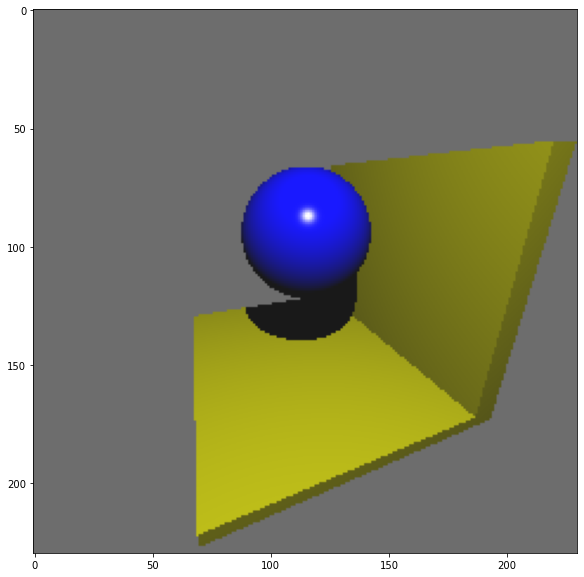

In [47]:
image = scene.render()
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [101]:
lights = [luz1]

In [102]:
cor_de_fundo = novo(0.428, 0.428, 0.428)
scene = Scene(camera, objects, lights, luzAmbiente, cor_de_fundo)

In [50]:
image = scene.render()
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

KeyboardInterrupt: 

In [103]:
lights = [luz1, luz2]

In [104]:
cor_de_fundo = novo(0.428, 0.428, 0.428)
scene = Scene(camera, objects, lights, luzAmbiente, cor_de_fundo)

In [ ]:
image = scene.render()
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [105]:
centro = novo(0, 20, 0)
raio = 25
difusa = novo(0, 0, 1)
especular = novo(1, 1, 1)
ambiente = novo(0.1, 0.1, 0.1)
reflexao = 0
brilho = 50
textura = "textura.jpg"
material = Material(difusa, especular, ambiente, reflexao, brilho, textura)
esfera = Esfera(centro, raio, material)

In [106]:
camera = Camera(500, 500, 90, 30)
eye = novo(100, 40, 40)
center = novo(0, 0, 0)
up = novo(0, 1, 0)
camera.posicao(eye, center, up)

In [107]:
objects = [esfera, caixa1, caixa2]

In [108]:
cor_de_fundo = novo(0.428, 0.428, 0.428)
scene = Scene(camera, objects, lights, luzAmbiente, cor_de_fundo)

In [ ]:
image = scene.render()
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [109]:
centro = novo(0, 20, 0)
raio = 25
difusa = novo(0, 0, 1)
especular = novo(1, 1, 1)
ambiente = novo(0.1, 0.1, 0.1)
reflexao = 0
brilho = 50
material = Material(difusa, especular, ambiente, reflexao, brilho, textura)
esfera = Esfera(centro, raio, material)

In [110]:
camera = Camera(230, 230, 90, 30)
eye = novo(100, 40, 40)
center = novo(0, 0, 0)
up = novo(0, 1, 0)
camera.posicao(eye, center, up)

In [121]:
objects = [esfera, caixa1, caixa2]

In [120]:
difusa = novo(0.7, 0.7, 0)
especular = novo(1, 1, 1)
ambiente = novo(0.1, 0.1, 0.1)
reflexao = 0
brilho = 50
material = Material(difusa, especular, ambiente, reflexao, brilho)
caixa1 = Caixa([-80, -50, -50], [50, -45, 50], material)
reflexao = 0
difusa = novo(0, 0, 1)
especular = novo(1, 1, 1)
ambiente = novo(0.1, 0.1, 0.1)
reflexao = 0
brilho = 50
textura = "textura.jpg"
material = Material(difusa, especular, ambiente, reflexao, brilho, textura)
caixa2 = Caixa([-80, -50, -60], [50, 50, -50], material)

In [122]:
cor_de_fundo = novo(0.428, 0.428, 0.428)
scene = Scene(camera, objects, lights, luzAmbiente, cor_de_fundo)

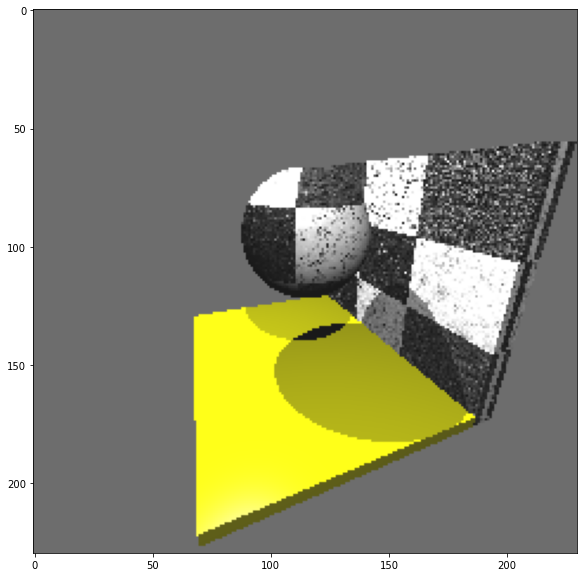

In [123]:
image = scene.render()
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [ ]:
cor_de_fundo = novo(0.428, 0.428, 0.428)
scene = Scene(camera, objects, lights, luzAmbiente, cor_de_fundo)

In [ ]:
class Scene2:
    def __init__(self, camera, objects, lights, ambiente, background):
        self.camera = camera
        self.objects = objects
        self.lights = lights
        self.ambiente = ambiente
        self.background = background
        self.iteracoes = 3
        
    def nearest_intersected_object(self, ray_origin, ray_direction):
        distances = [obj.intercepta(ray_origin, ray_direction) for obj in self.objects]
        nearest_object = None
        min_distance = np.inf
        for index, distance in enumerate(distances):
            if distance and distance < min_distance:
                min_distance = distance
                nearest_object = self.objects[index]
        return nearest_object, min_distance

    def ray_trace(self, origin, direction, iteration=0):
        # check for intersections
        nearest_object, min_distance = self.nearest_intersected_object(origin, direction)
        if nearest_object is None:
            return self.background

        # compute intersection point between ray and nearest object
        intersection = origin + min_distance * direction
        
        normal_to_surface = nearest_object.normal(intersection)
        shifted_point = intersection + 1e-5 * normal_to_surface
        
        normal = normalize(nearest_object.normal(intersection))
        material = nearest_object.material
        cor = novo(0.0, 0.0, 0.0)
        cor += self.ambiente.calcula_ambiente(material.ambiente)
        for light in self.lights:
            intersection_to_light = normalize(light.posicao - shifted_point)
            _, min_distance = self.nearest_intersected_object(shifted_point, intersection_to_light)
            intersection_to_light_distance = np.linalg.norm(light.posicao - intersection)
            is_shadowed = min_distance < intersection_to_light_distance
            
            if not is_shadowed:
                #return material.difusa
                l = normalize(light.posicao - intersection)
                n = normal
                r = normalize(2 * np.dot(l, n) * n - l)
                v = normalize(self.camera.origem() - intersection)
                cor += light.calcula_difusa_especular(material.difusa, l, n, material.especular, r, v, material.brilho)
                
        if material.reflexao > 0 and iteration < self.iteracoes:
            r = normalize(direction - 2 * np.dot(direction, normal) * normal)
            cor = material.reflexao * self.ray_trace(shifted_point, r, iteration + 1)
            
        return np.clip(cor, 0, 1)
    
        # compute intersection point between ray and nearest object
        intersection = origin + min_distance * direction
        
        normal_to_surface = nearest_object.normal(intersection)
        shifted_point = intersection + 1e-5 * normal_to_surface
        intersection_to_light = normalize(light['position'] - shifted_point)

        _, min_distance = self.nearest_intersected_object(shifted_point, intersection_to_light)
        intersection_to_light_distance = np.linalg.norm(light['position'] - intersection)
        #print(normal_to_surface)
        is_shadowed = min_distance < intersection_to_light_distance
        
        # RGB
        illumination = np.zeros((3))

        if is_shadowed:
            #print("sombra")
            return illumination

        # ambiant
        illumination += nearest_object.ambient * light['ambient']

        # diffuse
        illumination += nearest_object.diffuse * light['diffuse'] * np.dot(intersection_to_light, normal_to_surface)

        # specular
        intersection_to_camera = normalize(self.camera.origem() - intersection)
        H = normalize(intersection_to_light + intersection_to_camera)
        illumination += nearest_object.specular * light['specular'] * np.dot(normal_to_surface, H) ** (nearest_object.shininess / 4)
        
        return np.clip(illumination, 0, 1)

    def render(self):
        image = np.zeros((self.camera.w, self.camera.h, 3))
        origin = self.camera.origem()
        for y, x in itertools.product(range(self.camera.w), range(self.camera.h)):
            direction = self.camera.direcao(x, y)
            image[y, x] = self.ray_trace(origin, direction)
        return image


In [ ]:
centro = novo(0, 20, 0)
raio = 25
difusa = novo(0, 0, 1)
especular = novo(1, 1, 1)
ambiente = novo(0.1, 0.1, 0.1)
reflexao = 0
brilho = 50
material = Material(difusa, especular, ambiente, reflexao, brilho)
esfera = Esfera(centro, raio, material)

In [ ]:
difusa = novo(0.7, 0.7, 0)
especular = novo(1, 1, 1)
ambiente = novo(0.1, 0.1, 0.1)
reflexao = 0
brilho = 50
material = Material(difusa, especular, ambiente, reflexao, brilho)
caixa1 = cria_caixa([-80, -50, -50], [50, -45, 50], material)
reflexao = 0.8
material = Material(difusa, especular, ambiente, reflexao, brilho)
caixa2 = cria_caixa([-80, -50, -60], [50, 50, -50], material)

In [ ]:
objects = [esfera, caixa1, caixa2]

In [ ]:
posicao = novo(0, 0, 0)
difusa = novo(1, 1, 1)
especular = novo(1, 1, 1)
ambiente = novo(1, 1, 1)
luzAmbiente = Luz(posicao, difusa, especular, ambiente)
posicao = novo(60, 120, 40)
luz1 = Luz(posicao, difusa, especular, ambiente)
posicao = novo(-10, 120, 40)
luz1 = Luz(posicao, difusa, especular, ambiente)
posicao = novo(120, 120, 40)
luz2 = Luz(posicao, difusa, especular, ambiente)

In [ ]:
lights = [luz2]

In [ ]:
cor_de_fundo = novo(0.428, 0.428, 0.428)
scene = Scene2(camera, objects, lights, luzAmbiente, cor_de_fundo)

In [ ]:
image = scene.render()
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [ ]:
class Scene3:
    def __init__(self, camera, objects, lights, ambiente, background):
        self.camera = camera
        self.objects = objects
        self.lights = lights
        self.ambiente = ambiente
        self.background = background
        self.iteracoes = 3
        
    def nearest_intersected_object(self, ray_origin, ray_direction):
        distances = [obj.intercepta(ray_origin, ray_direction) for obj in self.objects]
        nearest_object = None
        min_distance = np.inf
        for index, distance in enumerate(distances):
            if distance and distance < min_distance:
                min_distance = distance
                nearest_object = self.objects[index]
        return nearest_object, min_distance

    def ray_trace(self, origin, direction, iteration=0):
        reflection = 1
        cor = np.zeros((3))
        for it in range(self.iteracoes):
            # check for intersections
            nearest_object, min_distance = self.nearest_intersected_object(origin, direction)
            if nearest_object is None:
                return self.background

            # compute intersection point between ray and nearest object
            intersection = origin + min_distance * direction

            normal_to_surface = nearest_object.normal(intersection)
            shifted_point = intersection + 1e-5 * normal_to_surface

            normal = normalize(nearest_object.normal(intersection))
            material = nearest_object.material
            iluminacao = self.ambiente.calcula_ambiente(material.ambiente)
            for light in self.lights:
                intersection_to_light = normalize(light.posicao - shifted_point)
                _, min_distance = self.nearest_intersected_object(shifted_point, intersection_to_light)
                intersection_to_light_distance = np.linalg.norm(light.posicao - intersection)
                is_shadowed = min_distance < intersection_to_light_distance

                if not is_shadowed:
                    #return material.difusa
                    l = normalize(light.posicao - intersection)
                    n = normal
                    r = normalize(2 * np.dot(l, n) * n - l)
                    v = normalize(self.camera.origem() - intersection)
                    iluminacao += light.calcula_difusa_especular(material.difusa, l, n, material.especular, r, v, material.brilho)
            
            cor += reflection * iluminacao
            reflection *= material.reflexao
            
            origin = shifted_point
            direction = direction - 2 * np.dot(direction, normal) * normal
            direction = normalize(direction)
        return np.clip(cor, 0, 1)
    
        # compute intersection point between ray and nearest object
        intersection = origin + min_distance * direction
        
        normal_to_surface = nearest_object.normal(intersection)
        shifted_point = intersection + 1e-5 * normal_to_surface
        intersection_to_light = normalize(light['position'] - shifted_point)

        _, min_distance = self.nearest_intersected_object(shifted_point, intersection_to_light)
        intersection_to_light_distance = np.linalg.norm(light['position'] - intersection)
        #print(normal_to_surface)
        is_shadowed = min_distance < intersection_to_light_distance
        
        # RGB
        illumination = np.zeros((3))

        if is_shadowed:
            #print("sombra")
            return illumination

        # ambiant
        illumination += nearest_object.ambient * light['ambient']

        # diffuse
        illumination += nearest_object.diffuse * light['diffuse'] * np.dot(intersection_to_light, normal_to_surface)

        # specular
        intersection_to_camera = normalize(self.camera.origem() - intersection)
        H = normalize(intersection_to_light + intersection_to_camera)
        illumination += nearest_object.specular * light['specular'] * np.dot(normal_to_surface, H) ** (nearest_object.shininess / 4)
        
        return np.clip(illumination, 0, 1)

    def render(self):
        image = np.zeros((self.camera.w, self.camera.h, 3))
        origin = self.camera.origem()
        for y, x in itertools.product(range(self.camera.w), range(self.camera.h)):
            direction = self.camera.direcao(x, y)
            image[y, x] = self.ray_trace(origin, direction)
        return image

In [ ]:
cor_de_fundo = novo(0.428, 0.428, 0.428)
scene = Scene3(camera, objects, lights, luzAmbiente, cor_de_fundo)

In [ ]:
difusa = novo(0.7, 0.7, 0)
especular = novo(1, 1, 1)
ambiente = novo(0.1, 0.1, 0.1)
reflexao = 0
brilho = 50
material = Material(difusa, especular, ambiente, reflexao, brilho)
caixa1 = cria_caixa([-80, -50, -50], [50, -45, 50], material)
reflexao = 0.5
material = Material(difusa, especular, ambiente, reflexao, brilho)
caixa2 = cria_caixa([-80, -50, -60], [50, 50, -50], material)

In [ ]:
objects = [esfera, caixa1, caixa2]

In [ ]:
image = scene.render()
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [ ]:
class Scene4:
    def __init__(self, camera, objects, lights, ambiente, background):
        self.camera = camera
        self.objects = objects
        self.lights = lights
        self.ambiente = ambiente
        self.background = background
        self.iteracoes = 3
        
    def nearest_intersected_object(self, ray_origin, ray_direction):
        distances = [obj.intercepta(ray_origin, ray_direction) for obj in self.objects]
        nearest_object = None
        min_distance = np.inf
        for index, distance in enumerate(distances):
            if distance and distance < min_distance:
                min_distance = distance
                nearest_object = self.objects[index]
        return nearest_object, min_distance

    def ray_trace(self, origin, direction, iteration=0):
        # check for intersections
        nearest_object, min_distance = self.nearest_intersected_object(origin, direction)
        if nearest_object is None:
            return self.background

        # compute intersection point between ray and nearest object
        intersection = origin + min_distance * direction
        for light in self.lights:
            light_direction = normalize(luz.posicao - intersection)
            

            if not is_shadowed:
                #return material.difusa
                l = normalize(light.posicao - intersection)
                n = normal
                r = normalize(2 * np.dot(l, n) * n - l)
                v = normalize(self.camera.origem() - intersection)
                cor += light.calcula_difusa_especular(material.difusa, l, n, material.especular, r, v, material.brilho)
        return np.clip(cor, 0, 1)
    
        # compute intersection point between ray and nearest object
        intersection = origin + min_distance * direction
        
        normal_to_surface = nearest_object.normal(intersection)
        shifted_point = intersection + 1e-5 * normal_to_surface
        intersection_to_light = normalize(light['position'] - shifted_point)

        _, min_distance = self.nearest_intersected_object(shifted_point, intersection_to_light)
        intersection_to_light_distance = np.linalg.norm(light['position'] - intersection)
        #print(normal_to_surface)
        is_shadowed = min_distance < intersection_to_light_distance
        
        # RGB
        illumination = np.zeros((3))

        if is_shadowed:
            #print("sombra")
            return illumination

        # ambiant
        illumination += nearest_object.ambient * light['ambient']

        # diffuse
        illumination += nearest_object.diffuse * light['diffuse'] * np.dot(intersection_to_light, normal_to_surface)

        # specular
        intersection_to_camera = normalize(self.camera.origem() - intersection)
        H = normalize(intersection_to_light + intersection_to_camera)
        illumination += nearest_object.specular * light['specular'] * np.dot(normal_to_surface, H) ** (nearest_object.shininess / 4)
        
        return np.clip(illumination, 0, 1)

    def render(self):
        image = np.zeros((self.camera.w, self.camera.h, 3))
        origin = self.camera.origem()
        for y, x in itertools.product(range(self.camera.w), range(self.camera.h)):
            direction = self.camera.direcao(x, y)
            image[y, x] = self.ray_trace(origin, direction)
        return image